<a href="https://colab.research.google.com/github/talhaakbarmohal/devops-mlops-tools/blob/main/MLFLOW_and_Optuna_Minist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install mlflow

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import mlflow
import mlflow.pytorch

### Model Training and MLflow Integration Checklist

**1. Log Training Statistics**

Track metrics such as loss, accuracy, etc. during training.

Use mlflow.log_metric() for logging metrics.

Use mlflow.log_param() for logging hyperparameters (e.g., learning rate, batch size).

**2. Save the Model**

Use mlflow.<framework>.log_model() to log the trained model (e.g., mlflow.sklearn.log_model() for scikit-learn, mlflow.pytorch.log_model() for PyTorch).

This allows you to retrieve the model later from the MLflow tracking server.

**3. Register the Model**

Register the logged model to the MLflow Model Registry using mlflow.register_model() or through the MLflow UI.

Enables versioning and deployment of your model.

**4. Load the Model for Inference**

Use mlflow.<framework>.load_model() to load the saved model.

Perform inference using the loaded model as you would normally.

There are two ways to log training information in MLflow:
1. Autologging
2. Manual logging.

In this tutorial, we will use manual logging for a clearer and more detailed understanding of how MLflow works under the hood.

This line of code connects to the MLflow server, where all our logs will be stored. It allows us to track our experiments, view the best results, and manage models through the MLflow UI interface.
`mlflow.set_tracking_uri("http://<ip>:5000")`
You can use MLflow to compare, share, and deploy the best models produced by the team.
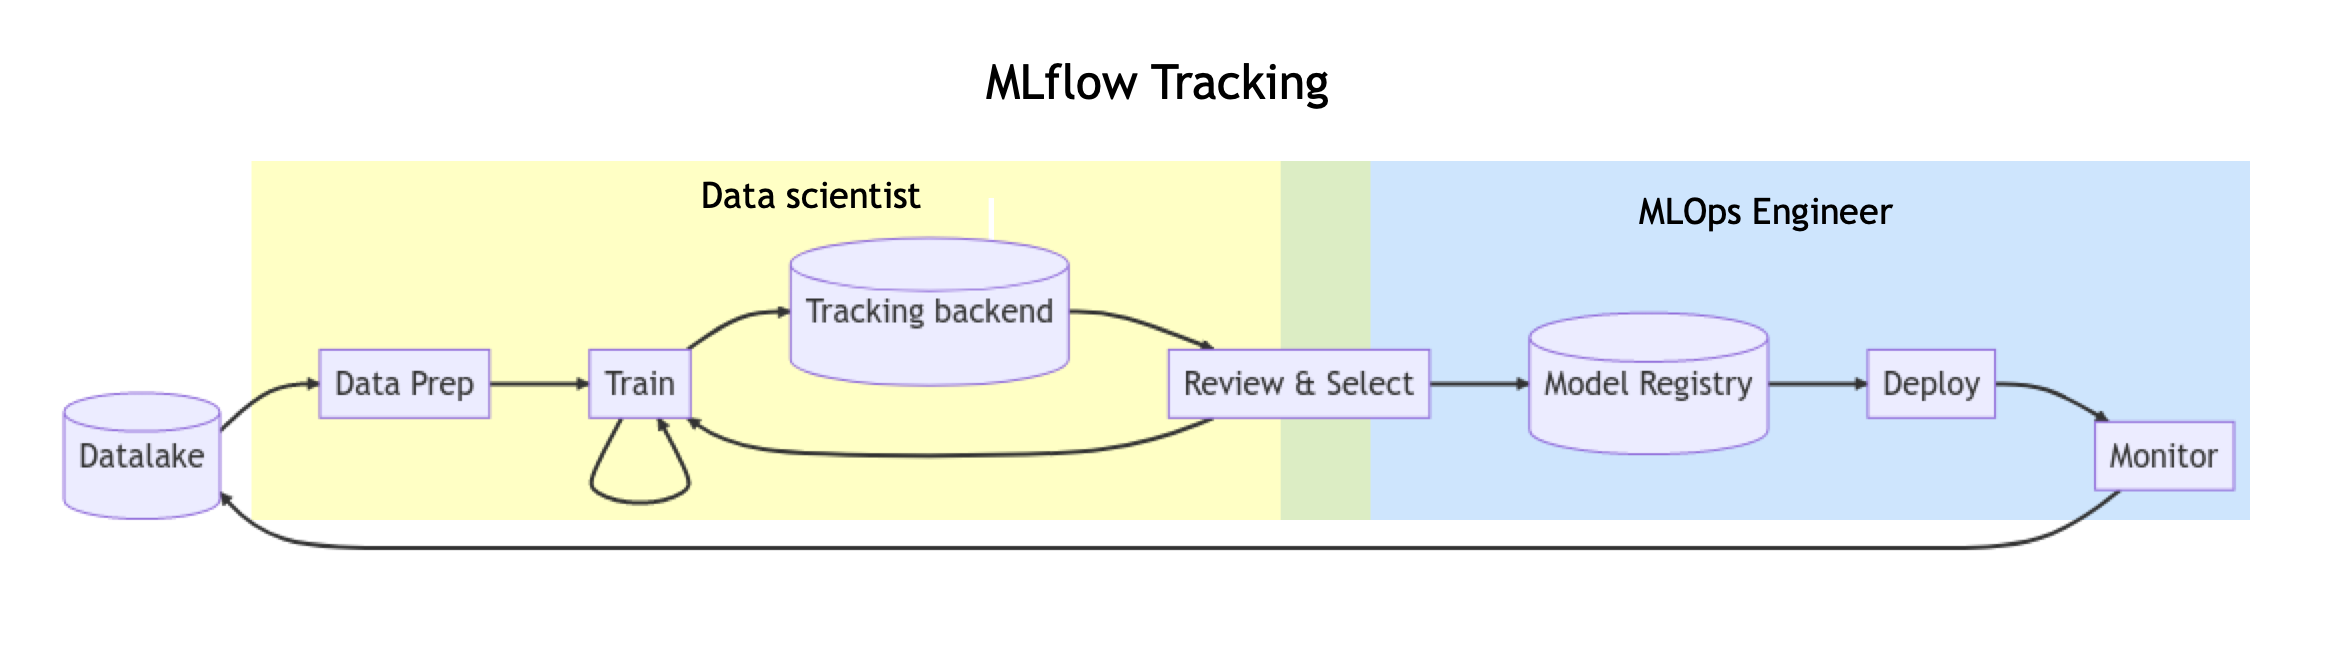

In [ ]:
mlflow.set_tracking_uri("http://<ip>:<port>")

I'm using Google Cloud Platform (GCP) and have set up a Virtual Machine (VM) instance. On this VM, I launched the MLflow tracking server to host the MLflow UI for tracking experiments and managing models.

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
mlflow.set_experiment("test_experiment")
with mlflow.start_run():
     mlflow.log_param("epochs", "2")

In [ ]:
tracking_uri = mlflow.get_tracking_uri()
print("Tracking URI:", tracking_uri)

# Check the artifact location set in the server
artifact_uri = mlflow.get_artifact_uri()
print("Artifact URI:", artifact_uri)

In [ ]:
import optuna


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform to convert images to tensor
transform = transforms.ToTensor()

In [ ]:
BATCH_SIZE = 8
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec
import numpy as np

input_schema = Schema([
    TensorSpec(np.dtype("float32"), shape=(1, 28, 28))
])

# Define output schema (single integer prediction: 0–9)
output_schema = Schema([
    TensorSpec(np.dtype("float32"), shape=(10,))
])


# Combine into a model signature
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, hidden_units=64):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.out = nn.Linear(hidden_units, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


`mlflow.set_experiment("MNIST_PyTorch_with_optuna")`


This line sets the current experiment where all the MLflow runs will be recorded. If the experiment with this name doesn’t exist, MLflow will automatically create it. Using a specific experiment helps you organize related runs together (e.g., all Optuna tuning runs for the MNIST project).

`with mlflow.start_run():`

This block starts a new run within the experiment. All parameters, metrics, models, and artifacts you log inside this block will be grouped under the same run. It ensures that everything related to this particular training or tuning trial is stored together and traceable in the MLflow UI.


In [ ]:
from mlflow.models import ModelSignature
from mlflow.types import Schema, ColSpec
from mlflow.types import DataType, TensorSpec

def train_model(hidden_units=64, learning_rate=0.001, epochs=1):
    model = SimpleNet(hidden_units)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    if mlflow.active_run():
      mlflow.end_run()

    #set experiment MLFLOW
    mlflow.set_experiment("MNIST_PyTorch_with_optuna")
    with mlflow.start_run():

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            acc = evaluate(model)
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

        return model, acc, avg_loss

In [ ]:
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100.0 * correct / total

In Optuna, the trial.suggest_* methods are used to define hyperparameter search spaces and tell the optimizer what values to sample from when running hyperparameter optimization.

`mlflow.log_param()`

This function is used to log hyperparameters or any configuration values used during training.

`mlflow.log_metric()`

This function is used to log performance metrics (like loss, accuracy, etc.) at any point during training or evaluation. For example:

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    hidden_units = trial.suggest_int('hidden_units', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    model, accuracy, avg_loss = train_model(hidden_units=hidden_units, learning_rate=learning_rate)

    # Log parameters and metrics to MLflow
    mlflow.log_param("hidden_units", hidden_units)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("loss", avg_loss)

    mlflow.pytorch.log_model(
            pytorch_model=model,
            artifact_path="model",
            signature=signature,
            input_example=torch.rand(1, 28, 28).numpy()
            )
    print("Model is logged at:", mlflow.get_artifact_uri("model"))
    return accuracy  # The objective for Optuna to optimize

When you create an Optuna study, it starts by initializing the study object. The study is connected to an optimization task where the objective function is repeatedly executed with different sets of hyperparameters, which are sampled by the study's trials. The study collects the results of each trial and evaluates which hyperparameter set performs the best.

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)  # Number of trials to run
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_trial.value}")

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Promote the model to the 'Production' stage
client.transition_model_version_stage(
    name='v1modeltesting',
    version=2,  # Version number to promote
    stage='Production'  # The stage you want to promote the model to
)

<ipython-input-237-54212aca7e15>:6: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1744312239073, current_stage='Production', description='', last_updated_timestamp=1744313874558, name='v1modeltesting', run_id='78103d582dc94ff99c8ad61c6fac3086', run_link='', source='gs://model-bucket-11/mlflow-artifacts/3/78103d582dc94ff99c8ad61c6fac3086/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='2'>

To download a registered model version from MLflow's Model Registry (specifically a model that is in the "Production" stage), you can use the MlflowClient to retrieve the model.

Use the Model for Inference: After loading the model, you can now use it for inference.

In [ ]:
model_uri = "models:/v1modeltesting/Production"
model = mlflow.pyfunc.load_model(model_uri)

In [ ]:
import pandas as pd
import numpy as np

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Get a single sample (image and label)
example_img, example_label = next(iter(test_loader))
input_df = example_img.reshape(1, 28, 28).numpy()
print(input_df.shape)  # (1, 784)

(1, 28, 28)


In [ ]:

# Predict using loaded model
predictions = model.predict(input_df)
print(predictions)
predicted_digit = torch.argmax(torch.tensor(predictions), dim=1).item()
print("Predicted digit:", predicted_digit)

[[-0.3117636 -0.8900159  6.8259916 -0.4390984 -6.202551  -1.819039
  -0.8588035 -1.7084701 -2.846357  -6.5301747]]
Predicted digit: 2


MLFLOW UI

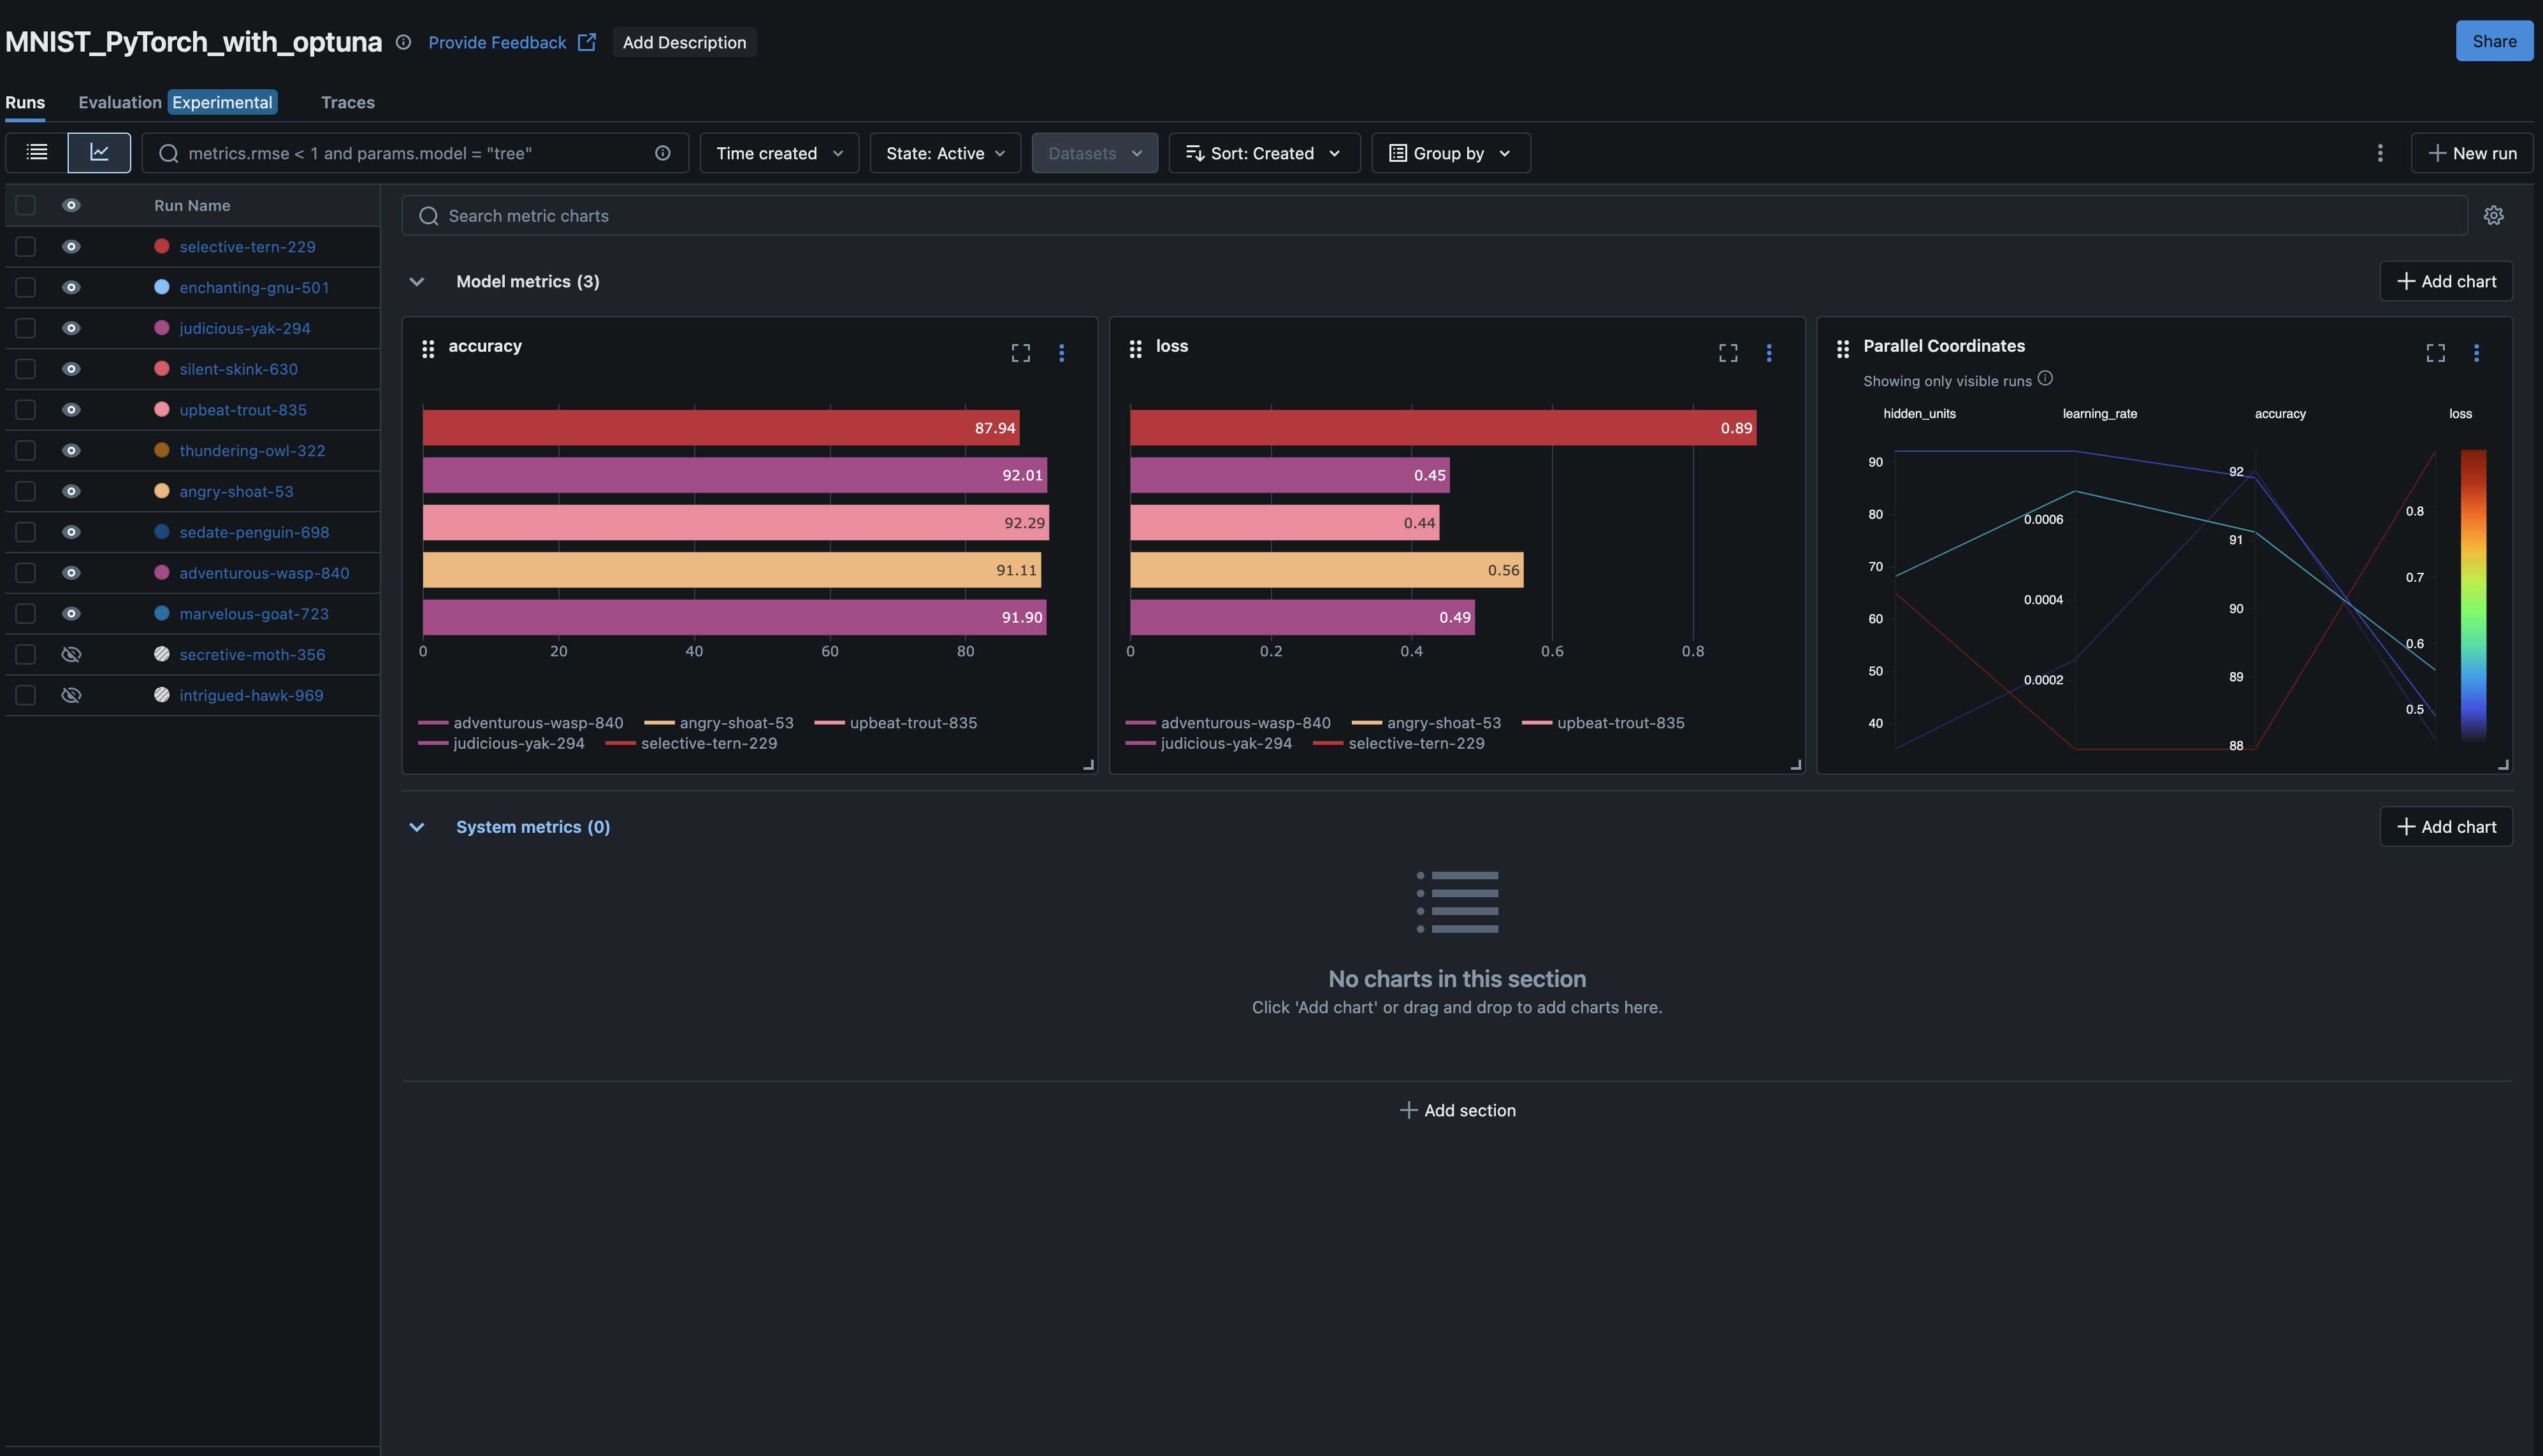